# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [187]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
import helper_functions
from sklearn.cluster import KMeans
from collections import OrderedDict


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [188]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [56]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [57]:
print(azdias.head())

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                     

In [58]:
print(feat_info.head())


              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
# Identify missing or unknown data values and convert them to NaNs.
def deal_with_missing(df, feat_info):
    fcopy = feat_info.copy() #do not change original feat_info, such we make a copy
    
    #first, replace all non numeric data values into nan 'X' and 'XX'
    df = df.replace('XX', np.nan)
    df = df.replace('X', np.nan)
    #then, loop thru feature info dataframe, and convert the remaining items
    for index, row in fcopy.iterrows():
        missing_value_array = np.fromstring( row['missing_or_unknown'].replace('[', '').replace(']', ''), sep=',')
        row['missing_or_unknown'] = missing_value_array

        for item in missing_value_array:
            df.loc[(df[row['attribute']] == item), row['attribute']] = np.nan
            
    return df
    


In [4]:
azdias = deal_with_missing(azdias, feat_info)

AGER_TYP
ALTERSKATEGORIE_GROB
ANREDE_KZ
CJT_GESAMTTYP
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GEBURTSJAHR
GFK_URLAUBERTYP
GREEN_AVANTGARDE
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ZABEOTYP
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
KK_KUNDENTYP
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
GEBAEUDETYP
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
WOHNLAGE
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
hist_data = []
for index, row in feat_info.iterrows():
    pct = (azdias[row['attribute']].isna().sum())/len(azdias[row['attribute']])
    hist_data.append(pct*100)
    print(f"{row['attribute']}: {pct:.2%}")

AGER_TYP: 76.96%
ALTERSKATEGORIE_GROB: 0.32%
ANREDE_KZ: 0.00%
CJT_GESAMTTYP: 0.54%
FINANZ_MINIMALIST: 0.00%
FINANZ_SPARER: 0.00%
FINANZ_VORSORGER: 0.00%
FINANZ_ANLEGER: 0.00%
FINANZ_UNAUFFAELLIGER: 0.00%
FINANZ_HAUSBAUER: 0.00%
FINANZTYP: 0.00%
GEBURTSJAHR: 44.02%
GFK_URLAUBERTYP: 0.54%
GREEN_AVANTGARDE: 0.00%
HEALTH_TYP: 12.48%
LP_LEBENSPHASE_FEIN: 10.95%
LP_LEBENSPHASE_GROB: 10.61%
LP_FAMILIE_FEIN: 8.73%
LP_FAMILIE_GROB: 8.73%
LP_STATUS_FEIN: 0.54%
LP_STATUS_GROB: 0.54%
NATIONALITAET_KZ: 12.15%
PRAEGENDE_JUGENDJAHRE: 12.14%
RETOURTYP_BK_S: 0.54%
SEMIO_SOZ: 0.00%
SEMIO_FAM: 0.00%
SEMIO_REL: 0.00%
SEMIO_MAT: 0.00%
SEMIO_VERT: 0.00%
SEMIO_LUST: 0.00%
SEMIO_ERL: 0.00%
SEMIO_KULT: 0.00%
SEMIO_RAT: 0.00%
SEMIO_KRIT: 0.00%
SEMIO_DOM: 0.00%
SEMIO_KAEM: 0.00%
SEMIO_PFLICHT: 0.00%
SEMIO_TRADV: 0.00%
SHOPPER_TYP: 12.48%
SOHO_KZ: 8.25%
TITEL_KZ: 99.76%
VERS_TYP: 12.48%
ZABEOTYP: 0.00%
ALTER_HH: 34.81%
ANZ_PERSONEN: 8.25%
ANZ_TITEL: 8.25%
HH_EINKOMMEN_SCORE: 2.06%
KK_KUNDENTYP: 65.60%
W_KEIT_KIND

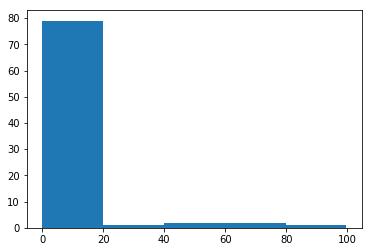

In [8]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(hist_data, bins=5)
plt.show()

In [44]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

def remove_outlier_columns(df, feat_info ):
#     for index, row in feat_info.iterrows():
#         pct = (df[row['attribute']].isna().sum())/len(df[row['attribute']])
#         if pct > threshold:
#             df = df.drop(row['attribute'], axis=1)
#             print(f"We dropped column {row['attribute']} because incomplete pct is {pct:.2%}")
    # we changed this to static so that it works on customer data
    df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1, inplace=True)
    
    return df
                  


In [ ]:
azdias = remove_outlier_columns(azdias, feat_info)

In [10]:
azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

For each column, we count the missing data vs the total data, such we get the missing data ratio. Looking at the histogram above, if incomplete ratio is bigger than 20% then we remove them.

We dropped column AGER_TYP because incomplete pct is 76.96%
We dropped column GEBURTSJAHR because incomplete pct is 44.02%
We dropped column TITEL_KZ because incomplete pct is 99.76%
We dropped column ALTER_HH because incomplete pct is 34.81%
We dropped column KK_KUNDENTYP because incomplete pct is 65.60%
We dropped column KBA05_BAUMAX because incomplete pct is 53.47%

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

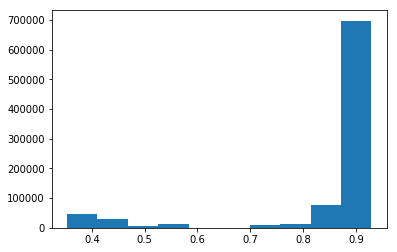

In [11]:
# How much data is missing in each row of the dataset?
not_nan_rows = azdias.count(axis=1)/len(feat_info)
plt.hist(not_nan_rows, bins=10)
plt.show()



In [6]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
#Looking At the Plot, it looks like we can exclude rows that are less than 90% complete
def remove_low_completed_rows(df, feat_info):
    row_completeness_ratio = df.count(axis=1)/len(feat_info)
    df['row_completeness_ratio'] = row_completeness_ratio
    
    good_df = df.loc[df['row_completeness_ratio'] >= 0.9]
    bad_df = df.loc[df['row_completeness_ratio'] < 0.9]
    
    good_df.drop(['row_completeness_ratio'], axis=1, inplace=True)
    bad_df.drop(['row_completeness_ratio'], axis=1, inplace=True)
    
    return good_df, bad_df



In [ ]:
good_azdias, bad_azdias = remove_low_completed_rows(azdias, feat_info)


In [14]:
print(len(bad_azdias))
bad_azdias.describe()

224348


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,row_completeness_ratio
count,221467.000000,224348.000000,219494.000000,224348.000000,224348.000000,224348.000000,224348.000000,224348.000000,224348.000000,224348.000000,...,107833.000000,107833.000000,107833.000000,107833.000000,107833.000000,107833.000000,127041.000000,127074.000000,127041.000000,224348.000000
mean,2.626802,1.549544,4.154792,3.085795,3.286029,3.223051,3.772336,3.808958,2.810009,3.443967,...,2.738596,1.502425,0.648466,1.838806,3.620571,3.474243,3.059863,5.079780,2.967200,0.669117
std,0.923515,0.497540,1.682154,1.184776,1.332552,1.084278,1.503611,1.409677,1.239119,1.629115,...,0.919075,0.982248,0.710322,1.410951,1.009813,1.099216,1.017857,2.307732,1.384235,0.214535
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.352941
25%,2.000000,1.000000,3.000000,3.000000,2.000000,3.000000,2.000000,3.000000,2.000000,2.000000,...,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,3.000000,2.000000,0.423529
50%,3.000000,2.000000,4.000000,3.000000,4.000000,3.000000,5.000000,5.000000,3.000000,4.000000,...,3.000000,1.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000,0.811765
75%,3.000000,2.000000,6.000000,4.000000,4.000000,4.000000,5.000000,5.000000,3.000000,4.000000,...,3.000000,2.000000,1.000000,2.000000,4.000000,4.000000,4.000000,7.000000,4.000000,0.858824
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000,0.894118


In [15]:
#find 5 worst offending columns in bad azdias
od = OrderedDict()
for index, row in feat_info.iterrows():
    if row['attribute'] in bad_azdias.columns:
        od[bad_azdias[row['attribute']].count() / len(bad_azdias)] = row['attribute']

In [16]:
od = OrderedDict(sorted(od.items())[:5]) #sort so the first 5 has the lowest row completeness ratio

In [17]:
print(od)

OrderedDict([(0.3734421523704245, 'W_KEIT_KIND_HH'), (0.4057268172660331, 'MOBI_REGIO'), (0.418724481608929, 'REGIOTYP'), (0.4806505963948865, 'PLZ8_GBZ'), (0.50435929894627984, 'VERS_TYP')])


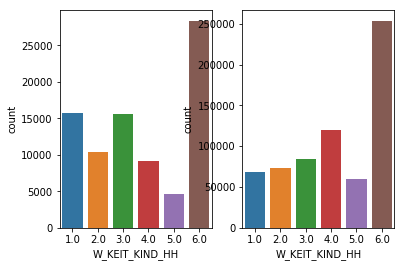

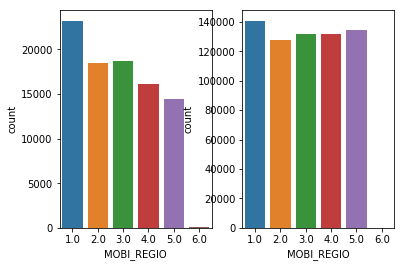

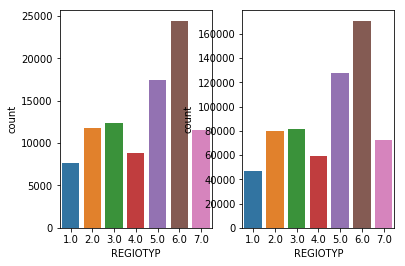

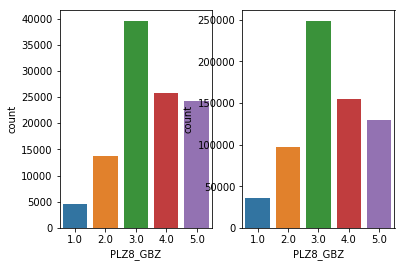

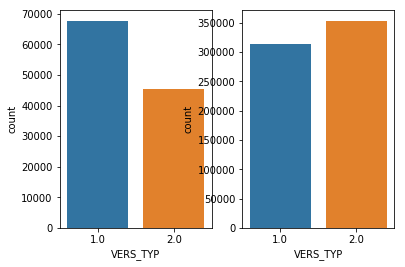

In [18]:
#Draw the comparison of the 5 worst columns distributions between bad_azdias and good_azdias
import seaborn as sns
  
def draw_plots(column_name):    
    fig, axes = plt.subplots(1,2)
    sns.countplot(x=column_name, data=bad_azdias, ax=axes[0])
    sns.countplot(x=column_name, data=good_azdias, ax=axes[1])
        
for key, value in od.items():
    draw_plots(value)
    

#### Discussion 1.1.3: Assess Missing Data in Each Row

So the QUESTION is: Are the data with lots of missing values are qualitatively different from data with few or no missing values?

ANSWER:
Yes. In the above analysis, I divided the azdias data into two groups: one with completed row that are 75% and above (good_azdias), and the other one with completed row lower than 90% (bad_azdias).

Then I iterate thru all rows in bad azdias, and I get the 5 offending columns from bad azdias. Offending column here are the columns with the lowest completion rate (with the most NA value)

Then I visualize the offending rows, comparing its distribution vs the good azdias.

As you can see that for the bad azdias, only a low number of rows are populated with real values, such we can't rely on those rows... such, we'll use good_azdias!


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
feat_info.groupby('type').count()


,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
for index, row in feat_info.iterrows():
    if row['type'] == 'categorical':
        if row['attribute'] in good_azdias.columns:
            print(row['attribute'])
            print(good_azdias[row['attribute']].unique())

    

ANREDE_KZ
[ 2.  1.]
CJT_GESAMTTYP
[ 5.  3.  2.  4.  1.  6.]
FINANZTYP
[ 1.  5.  2.  4.  6.  3.]
GFK_URLAUBERTYP
[ 10.   5.   1.  12.   9.   3.   8.  11.   4.   7.   6.   2.]
GREEN_AVANTGARDE
[0 1]
LP_FAMILIE_FEIN
[  5.   1.  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB
[ 3.  1.  5.  2.  4.]
LP_STATUS_FEIN
[  2.   3.   4.   1.  10.   9.   5.   8.   6.   7.]
LP_STATUS_GROB
[ 1.  2.  5.  4.  3.]
NATIONALITAET_KZ
[ 1.  2.  3.]
SHOPPER_TYP
[ 3.  2.  0.  1.]
SOHO_KZ
[ 1.  0.]
VERS_TYP
[ 2.  1.]
ZABEOTYP
[ 5.  4.  1.  6.  3.  2.]
GEBAEUDETYP
[ 8.  1.  3.  6.  2.  4.  5.]
OST_WEST_KZ
['W' 'O']
CAMEO_DEUG_2015
['8' '4' '6' '2' '1' '9' '5' '7' '3']
CAMEO_DEU_2015
['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '9B' '2A' '1B' '8B'
 '7A' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '5C' '9C' '7D' '5E'
 '1D' '8D' '6C' '5B' '7C' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C' '6A']


In [21]:
# Re-encode categorical variable(s) to be kept in the analysis.

#Replace OST_WEST_KZ to 0 and 1
good_azdias['OST_WEST_KZ'].dtypes
good_azdias['OST_WEST_KZ']=good_azdias['OST_WEST_KZ'].astype('category')
good_azdias['OST_WEST_KZ'] = good_azdias['OST_WEST_KZ'].cat.codes

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
good_azdias['OST_WEST_KZ'].value_counts()

1    522103
0    144770
Name: OST_WEST_KZ, dtype: int64

In [23]:
#drop multilevel categorical
for index, row in feat_info.iterrows():
    if row['type'] == 'categorical':
        if row['attribute'] in good_azdias and len(good_azdias[row['attribute']].unique()) > 2:
            good_azdias.drop(row['attribute'], axis=1, inplace=True)
            print(f"We are dropping {row['attribute']} because it is a multilevel categorical... just to make things simple")


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


We are dropping CJT_GESAMTTYP because it is a multilevel categorical... just to make things simple
We are dropping FINANZTYP because it is a multilevel categorical... just to make things simple
We are dropping GFK_URLAUBERTYP because it is a multilevel categorical... just to make things simple
We are dropping LP_FAMILIE_FEIN because it is a multilevel categorical... just to make things simple
We are dropping LP_FAMILIE_GROB because it is a multilevel categorical... just to make things simple
We are dropping LP_STATUS_FEIN because it is a multilevel categorical... just to make things simple
We are dropping LP_STATUS_GROB because it is a multilevel categorical... just to make things simple
We are dropping NATIONALITAET_KZ because it is a multilevel categorical... just to make things simple
We are dropping SHOPPER_TYP because it is a multilevel categorical... just to make things simple
We are dropping ZABEOTYP because it is a multilevel categorical... just to make things simple
We are dro

#### Discussion 1.2.1: Re-Encode Categorical Features

As you can see in the work above, this is what I did:
- Replaced OST_WEST_KZ to 0 and 1 (because originally they were not numerical)
- Dropped CAMEO_DEU_2015 because it is too complicated and I feel like it is already represented by the CAMEO_DEUG_2015
- Did one hot encodding for the below columns becuse I feel like they are important
'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',                                                    'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',                                           'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015'


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [109]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
good_azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    155884
8.0     119605
5.0      75075
10.0     72036
3.0      47145
15.0     35852
11.0     30129
9.0      30105
6.0      23575
12.0     21065
4.0      18847
1.0      16402
2.0       6390
13.0      4766
7.0       3655
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [7]:
def get_generation(input):
    if input == 1 or input == 2:
        return '40s'
    elif input in (3, 4):
        return '50s'
    elif input in (5,6,7):
        return '60s'
    elif input in (8, 9):
        return '70s'
    elif input in (10, 11, 12, 13):
        return '80s'
    elif input in (14, 15):
        return '90s'
    else:
        return np.nan
    
def get_movement(input):
    if input in (1, 3, 5, 8, 10, 12, 14):
        return 0
    elif input in (2, 4, 6, 7, 9, 11, 13, 15):
        return 1
    else:
        return np.nan
    

In [ ]:
good_azdias['GENERATION'] = good_azdias['PRAEGENDE_JUGENDJAHRE'].apply(get_generation)
#then do one hot encoding on the generation
good_azdias = pd.get_dummies(good_azdias, columns =['GENERATION'])
good_azdias ['MOVEMENT'] = good_azdias['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)


In [111]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
good_azdias['CAMEO_INTL_2015'].value_counts()



51    115237
41     78665
24     77496
14     53024
43     48585
54     39712
25     33724
22     26766
45     22982
13     21886
55     20441
23     17935
52     17431
34     15763
15     14859
31     14009
44     12666
12     10063
35      8861
32      8693
33      8075
Name: CAMEO_INTL_2015, dtype: int64

In [8]:
def get_wealth_category(input):
    if pd.isnull(input):
        return np.nan
    front = int(input)/10
    return front

def get_household_category(input):
    if pd.isnull(input):
        return np.nan
    back = int(input)%10
    return back



In [ ]:
good_azdias['WEALTH_CATEGORY'] = good_azdias['CAMEO_INTL_2015'].apply(get_wealth_category)
good_azdias['HOUSEHOLD_CATEGORY'] = good_azdias['CAMEO_INTL_2015'].apply(get_household_category) #lifestage

In [26]:
good_azdias['HOUSEHOLD_CATEGORY'].value_counts()

1    207911
4    198661
5    100867
3     96481
2     62953
Name: HOUSEHOLD_CATEGORY, dtype: int64

In [27]:
good_azdias = good_azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE','PLZ8_BAUMAX'], axis=1)


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

According to suggestion, I worked on PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.

I removed LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB because I feel like the information are represented in other columns already

I changed WOHNLAGE,PLZ8_BAUMAX into one-hot-encoding because looking at the data, it can be safely worked as categorical

KB05_BAUMAX was already dropped


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [115]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

for index, row in feat_info.iterrows():
    if row['attribute'] in good_azdias.columns:
        print(row['attribute'])
        print(good_azdias[row['attribute']].unique())


ALTERSKATEGORIE_GROB
[ 1.  3.  2.  4.]
ANREDE_KZ
[ 2.  1.]
FINANZ_MINIMALIST
[ 1.  4.  3.  2.  5.]
FINANZ_SPARER
[ 5.  4.  3.  1.  2.]
FINANZ_VORSORGER
[ 2.  1.  4.  5.  3.]
FINANZ_ANLEGER
[ 5.  2.  1.  4.  3.]
FINANZ_UNAUFFAELLIGER
[ 4.  3.  2.  5.  1.]
FINANZ_HAUSBAUER
[ 5.  2.  3.  4.  1.]
GREEN_AVANTGARDE
[0 1]
HEALTH_TYP
[ 3.  2.  1.]
PRAEGENDE_JUGENDJAHRE
[ 14.  15.   8.   3.  10.  11.   9.   6.   5.   4.  nan   2.   1.  12.  13.
   7.]
RETOURTYP_BK_S
[ 1.  3.  5.  4.  2.]
SEMIO_SOZ
[ 5.  4.  6.  2.  7.  3.  1.]
SEMIO_FAM
[ 4.  1.  5.  7.  2.  6.  3.]
SEMIO_REL
[ 4.  3.  7.  5.  1.  6.  2.]
SEMIO_MAT
[ 3.  2.  4.  7.  5.  1.  6.]
SEMIO_VERT
[ 1.  4.  7.  2.  6.  5.  3.]
SEMIO_LUST
[ 2.  4.  6.  3.  1.  7.  5.]
SEMIO_ERL
[ 2.  6.  4.  5.  7.  3.  1.]
SEMIO_KULT
[ 3.  6.  5.  7.  1.  2.  4.]
SEMIO_RAT
[ 6.  4.  2.  7.  5.  3.  1.]
SEMIO_KRIT
[ 4.  7.  3.  1.  5.  2.  6.]
SEMIO_DOM
[ 7.  2.  4.  1.  5.  6.  3.]
SEMIO_KAEM
[ 4.  7.  2.  3.  6.  1.  5.]
SEMIO_PFLICHT
[ 7.  3.  4.  5. 

In [28]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
good_azdias = good_azdias.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1)




### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [189]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = deal_with_missing(df, feat_info)
    print('done with deal_with_missing')
    
    # remove selected columns and rows, ...===========================
    df = remove_outlier_columns(df, feat_info)
    df, bad_df = remove_low_completed_rows(df, feat_info)
    print('done with removing outlier columns and low completed rows')

    
    # select, re-encode, and engineer column values.===========================
    
    #Replace OST_WEST_KZ to 0 and 1
    df['OST_WEST_KZ'].dtypes
    df['OST_WEST_KZ']=df['OST_WEST_KZ'].astype('category')
    df['OST_WEST_KZ'] =df['OST_WEST_KZ'].cat.codes

    #remove multilevel categorical to keep things simple and fast
    for index, row in feat_info.iterrows():
        if row['type'] == 'categorical':
            if row['attribute'] in df and len(df[row['attribute']].unique()) > 2:
                df.drop(row['attribute'], axis=1, inplace=True)
                print(f"We are dropping {row['attribute']} because it is a multilevel categorical... just to make things simple")

    
    df['GENERATION'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_generation)
    #then do one hot encoding on the generation
    df = pd.get_dummies(df, columns =['GENERATION'])

    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)
    
    df['WEALTH_CATEGORY'] = df['CAMEO_INTL_2015'].apply(get_wealth_category)
    df['HOUSEHOLD_CATEGORY'] = df['CAMEO_INTL_2015'].apply(get_household_category) #lifestage

    df = df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1)
    
    #take care of the remaining of mixed variable columns
    df = df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE','PLZ8_BAUMAX'], axis=1)

    # Return the cleaned dataframe.
    return df
    

In [190]:
good_azdias = clean_data(azdias, feat_info)

AGER_TYP
ALTERSKATEGORIE_GROB
ANREDE_KZ
CJT_GESAMTTYP
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GEBURTSJAHR
GFK_URLAUBERTYP
GREEN_AVANTGARDE
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ZABEOTYP
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
KK_KUNDENTYP
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
GEBAEUDETYP
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
WOHNLAGE
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


done with removing outlier columns and low completed rows
We are dropping CJT_GESAMTTYP because it is a multilevel categorical... just to make things simple
We are dropping FINANZTYP because it is a multilevel categorical... just to make things simple
We are dropping GFK_URLAUBERTYP because it is a multilevel categorical... just to make things simple
We are dropping LP_FAMILIE_FEIN because it is a multilevel categorical... just to make things simple
We are dropping LP_FAMILIE_GROB because it is a multilevel categorical... just to make things simple
We are dropping LP_STATUS_FEIN because it is a multilevel categorical... just to make things simple
We are dropping LP_STATUS_GROB because it is a multilevel categorical... just to make things simple
We are dropping NATIONALITAET_KZ because it is a multilevel categorical... just to make things simple
We are dropping SHOPPER_TYP because it is a multilevel categorical... just to make things simple
We are dropping ZABEOTYP because it is a multi

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [33]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# imp = Imputer(strategy='most_frequent', axis=0)

# for col in good_azdias.columns:
#     if good_azdias[col].isnull().values.any():
#         imp.fit(good_azdias[[col]])
#         new_col = imp.transform(good_azdias[[col]]).ravel()
#         good_azdias[col] = new_col
#         print(f"we impute this column: {col} with most_frequent imputer")
        

In [34]:
# Apply feature scaling to the general population demographics data.
#scaler = StandardScaler()
#good_azdias = pd.DataFrame(scaler.fit_transform(good_azdias), columns = good_azdias.columns)

In [11]:
#create a function here to be used by customers data

#impute all NA into most frequent, then standardize the values
def do_feature_scaling(df, scaler = None):
    imp = Imputer(strategy='most_frequent', axis=0)

    for col in df.columns:
        if df[col].isnull().values.any():
            imp.fit(df[[col]])
            new_col = imp.transform(df[[col]]).ravel()
            df[col] = new_col
            print(f"we impute this column: {col} with most_frequent imputer")

    if scaler==None:        
        scaler = StandardScaler()
    scaler.fit(df)    
    df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    
    return df, scaler



In [191]:
good_azdias, scaler_model = do_feature_scaling(good_azdias)

we impute this column: W_KEIT_KIND_HH with most_frequent imputer
we impute this column: ANZ_HAUSHALTE_AKTIV with most_frequent imputer
we impute this column: KONSUMNAEHE with most_frequent imputer
we impute this column: GEBAEUDETYP_RASTER with most_frequent imputer
we impute this column: KKK with most_frequent imputer
we impute this column: REGIOTYP with most_frequent imputer
we impute this column: KBA13_ANZAHL_PKW with most_frequent imputer
we impute this column: ARBEIT with most_frequent imputer
we impute this column: RELAT_AB with most_frequent imputer
we impute this column: MOVEMENT with most_frequent imputer


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

First, we handled remaining NA data. I chose to use "most_frequent" imputer to replace all NA into each column's most frequent value.
Then we applied StandardScaler (gaussian distribution with mean 0 and variance 1) to all columns

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [31]:
# Apply PCA to the data.
pca = PCA()
test = pca.fit_transform(good_azdias)


In [37]:
np.set_printoptions(precision=2, suppress =  True)
print(pca.explained_variance_ratio_)

[ 0.09  0.07  0.04  0.03  0.02  0.02  0.02  0.02  0.02  0.02  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0. 

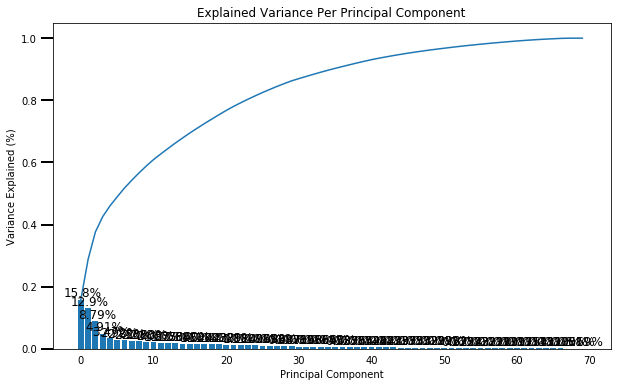

In [32]:
# Investigate the variance accounted for by each principal component.
helper_functions.scree_plot(pca)

In [40]:
#import dill
#dill.dump_session('notebook_env.db')

In [192]:
# Re-apply PCA to the data while selecting for number of components to retain.

#NOTE: looking at explained_variance_ratio, it makes sense to keep 45 components, this way we are keeping about 90% of the variance
def do_PCA90(df, pca_model = None):
    if pca_model == None:
        pca_model = PCA(n_components = 45 )
        pca_model.fit(df)
    transformed_df = pca_model.transform(df)
    return transformed_df, pca_model


In [193]:
pca_azdias, pca90 = do_PCA90(good_azdias)

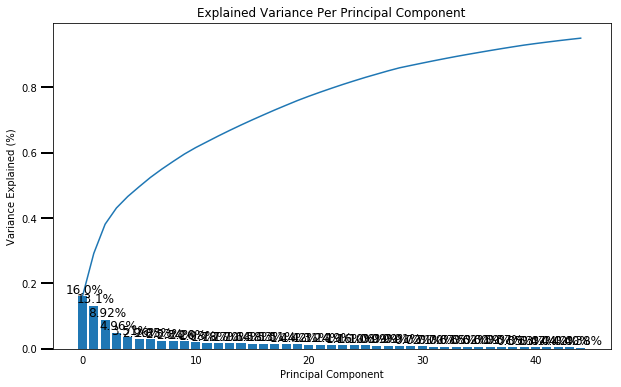

In [194]:
helper_functions.scree_plot(pca90)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

First we did a general PCA (without specifying the component) and did a skreeplot to see the explained variance by component. Looking at the graph, we see that if we keep 84 components, then it'll explain about 90% of the variance, such we chose 84 components.





### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [17]:
column_names = good_azdias.columns

def print_PCA_component(column_names, pca, index):
    component_weights = pca90.components_[index]
    od = OrderedDict(zip(component_weights,column_names))
    od_sorted = OrderedDict(sorted(od.items(), reverse=True)) 

    for key, value in od_sorted.items():
        print(f"{value}: {key}")

In [24]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
print(f"first var ratio: {pca90.explained_variance_ratio_[0]}")
print_PCA_component(column_names, pca90, 0)

first var ratio: 0.16039891704782297
PLZ8_ANTG3: 0.21388662163570304
PLZ8_ANTG4: 0.20751228131608432
HH_EINKOMMEN_SCORE: 0.19547601793413444
WEALTH_CATEGORY: 0.192808868095692
ORTSGR_KLS9: 0.18521761932284186
EWDICHTE: 0.1825479230289006
FINANZ_SPARER: 0.16643810915543059
FINANZ_HAUSBAUER: 0.14733467442123374
KBA05_ANTG4: 0.14548906960445132
PLZ8_ANTG2: 0.14358957479467416
ARBEIT: 0.13626572588169117
SEMIO_PFLICHT: 0.13328331323598902
KBA05_ANTG3: 0.13155577366059312
SEMIO_REL: 0.13128572852461487
ANZ_HAUSHALTE_AKTIV: 0.13015716098202132
RELAT_AB: 0.12575571853260328
SEMIO_TRADV: 0.11712686590338486
GENERATION_90s: 0.11630351599707649
SEMIO_RAT: 0.11036897563676719
FINANZ_UNAUFFAELLIGER: 0.0971835621506891
SEMIO_MAT: 0.09581624339369399
SEMIO_FAM: 0.09259571498630423
SEMIO_KULT: 0.09098902533348369
FINANZ_ANLEGER: 0.0858302625978388
REGIOTYP: 0.061995604238620376
SEMIO_SOZ: 0.05246801711847563
KKK: 0.04104671672029858
PLZ8_HHZ: 0.03821743253314115
HEALTH_TYP: 0.03409456511553998
ANZ_HH

In [21]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(f"second var ratio: {pca90.explained_variance_ratio_[1]}")

print_PCA_component(column_names, pca90, 1)


second var ratio: 0.13157365002827517
ALTERSKATEGORIE_GROB: 0.24241406560682738
SEMIO_ERL: 0.21632027602710097
FINANZ_VORSORGER: 0.21466822521945544
SEMIO_LUST: 0.16906613146887073
RETOURTYP_BK_S: 0.16230922473887585
FINANZ_HAUSBAUER: 0.13017966350352841
W_KEIT_KIND_HH: 0.11993530865663096
PLZ8_ANTG3: 0.11797054043051791
SEMIO_KRIT: 0.11475110147549385
GENERATION_60s: 0.11418184458446946
PLZ8_ANTG4: 0.11314557947671092
EWDICHTE: 0.11052168933941328
ORTSGR_KLS9: 0.1098885119355635
SEMIO_KAEM: 0.10746942847000124
GENERATION_50s: 0.10245667707028898
WEALTH_CATEGORY: 0.09889576318374986
KBA05_ANTG4: 0.08666413702750879
ARBEIT: 0.08231192781399713
ANREDE_KZ: 0.08192211232768193
PLZ8_ANTG2: 0.07952599180691731
RELAT_AB: 0.07781612079528052
ANZ_HAUSHALTE_AKTIV: 0.07617231985138233
HH_EINKOMMEN_SCORE: 0.07473143205809309
SEMIO_DOM: 0.06332555173224619
GENERATION_40s: 0.06260476975717892
KBA05_ANTG3: 0.06162633714484742
GENERATION_70s: 0.05847042069744476
WOHNDAUER_2008: 0.05078338886949071
FIN

In [23]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(f"third var ratio: {pca90.explained_variance_ratio_[2]}")
print_PCA_component(column_names, pca90, 2)



third var ratio: 0.08925099649857625
SEMIO_VERT: 0.34882887385226075
SEMIO_SOZ: 0.26590437160097974
SEMIO_FAM: 0.25664479143278723
SEMIO_KULT: 0.23860943432413478
FINANZ_MINIMALIST: 0.1540673093558354
RETOURTYP_BK_S: 0.1118376566609458
FINANZ_VORSORGER: 0.09319779962100533
W_KEIT_KIND_HH: 0.0888995420124821
SEMIO_REL: 0.08724290536420497
ALTERSKATEGORIE_GROB: 0.07493574880859247
SEMIO_LUST: 0.06804913351004989
SEMIO_MAT: 0.05824016182427256
GENERATION_60s: 0.05539692723864942
GENERATION_50s: 0.05069674189656027
GREEN_AVANTGARDE: 0.048429341909699795
MOVEMENT: 0.04842934190969979
EWDICHTE: 0.04543298603875946
ORTSGR_KLS9: 0.04526098112350926
PLZ8_ANTG4: 0.04366354269438544
PLZ8_ANTG3: 0.04306964694481827
WOHNDAUER_2008: 0.03319765426685523
ARBEIT: 0.030879303165439208
RELAT_AB: 0.02939932293324883
PLZ8_ANTG2: 0.028950942300045513
KBA05_ANTG4: 0.026956049856433597
GENERATION_40s: 0.0262218274078641
ANZ_HAUSHALTE_AKTIV: 0.02497313428690191
WEALTH_CATEGORY: 0.02436848633621631
VERS_TYP: 0.

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

The first component, explained about 16.03% of variance... Looking at the component, here are the top 5 biggest contributors:
* PLZ8_ANTG3: 0.21388662163570304
* PLZ8_ANTG4: 0.20751228131608432
* HH_EINKOMMEN_SCORE: 0.19547601793413444
* WEALTH_CATEGORY: 0.192808868095692
* ORTSGR_KLS9: 0.18521761932284186

It makes sense that all of these 5 variables are correlated in explaining how wealthy/poor this individual, with the column HH_EINKOMMEN_SCORE (household net income) is the key explainer of "how wealthy" while the other variables are about the community of where they live (wealthy neighborhood or poor)

The second component, explained about 13.15% of variance, looking at the component, here are the top 5 biggest contributors:
* ALTERSKATEGORIE_GROB: 0.24241406560682738
* SEMIO_ERL: 0.21632027602710097
* FINANZ_VORSORGER: 0.21466822521945544
* SEMIO_LUST: 0.16906613146887073
* RETOURTYP_BK_S: 0.16230922473887585

The second component here is correlated in explaining the individual age and his/her financial/social behavior. Looks like the age bracket is positively correlated with being financially prepared and how they behave socially (event oriented and sensual oriented)


The third component, explained about 9.2% in variance. Here are the top 5 biggest contributors:
* SEMIO_VERT: 0.34882887385226075
* SEMIO_SOZ: 0.26590437160097974
* SEMIO_FAM: 0.25664479143278723
* SEMIO_KULT: 0.23860943432413478
* FINANZ_MINIMALIST: 0.1540673093558354

The third component here is correlated in explaining the individual personality and financial/social behavior. I would guess that if a person is family oriented and like to save, then they will probably will correlate higher with a higher income bracket.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [38]:
# Over a number of different cluster counts... THIS TAKES A REALLY LONG TIME.... I USUALLY JUST SKIP
k = (10, 20, 25, 30)
scores = []
def get_kmeans_score(data, k):  # compute the average within-cluster distances.
    print(f"Working on k={k}")
    km = KMeans(n_clusters = k)
    km.fit(data)
    score = abs(km.score(data))
    return score
    
for i in k:
    scores.append(get_kmeans_score(pca_azdias, i))
    
    

Working on k=10
Working on k=20
Working on k=25
Working on k=30


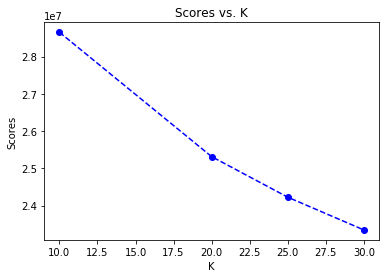

In [39]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(k, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Scores');
plt.title('Scores vs. K');    
    


In [94]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

def do_kmeans(df, km_model = None):
    if km_model == None:
        km_model = KMeans(n_clusters = 20) #for speed consideration
        km_model_fitted= km_model.fit(df)
    else:
        km_model_fitted = km_model
            
    score = abs(km_model_fitted.score(df))
    labels = km_model_fitted.predict(df)
    return km_model_fitted, score, labels

In [166]:
km_model, score, kmeans_labels = do_kmeans(pca_azdias)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

using the elbow method, we see that around 20, the clustering looks sufficient, plus the more cluster we do, the slower the computation, so 20 is an optimal number in our case.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [195]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [196]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers, feat_info)
print('done cleaning data')

customers, scaler_model = do_feature_scaling(customers, scaler = scaler_model) #scaler model obtained previously
print('done feature scaling')

pca_customer, pca90 = do_PCA90(customers, pca_model = pca90)
print('done pca')

km_model, score, customer_kmeans_label = do_kmeans(pca_customer, km_model = km_model)
print('done kmeans')



AGER_TYP
ALTERSKATEGORIE_GROB
ANREDE_KZ
CJT_GESAMTTYP
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GEBURTSJAHR
GFK_URLAUBERTYP
GREEN_AVANTGARDE
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ZABEOTYP
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
KK_KUNDENTYP
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
GEBAEUDETYP
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
WOHNLAGE
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


done with removing outlier columns and low completed rows
We are dropping CJT_GESAMTTYP because it is a multilevel categorical... just to make things simple
We are dropping FINANZTYP because it is a multilevel categorical... just to make things simple
We are dropping GFK_URLAUBERTYP because it is a multilevel categorical... just to make things simple
We are dropping LP_FAMILIE_FEIN because it is a multilevel categorical... just to make things simple
We are dropping LP_FAMILIE_GROB because it is a multilevel categorical... just to make things simple
We are dropping LP_STATUS_FEIN because it is a multilevel categorical... just to make things simple
We are dropping LP_STATUS_GROB because it is a multilevel categorical... just to make things simple
We are dropping NATIONALITAET_KZ because it is a multilevel categorical... just to make things simple
We are dropping SHOPPER_TYP because it is a multilevel categorical... just to make things simple
We are dropping ZABEOTYP because it is a multi

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [197]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def create_bins_from_kmeans_labels(labels):
    bins = [0] * 20
    x = np.arange(0,20) #label for the histogram
    for item in labels:
        bins[item] += 1
    return bins, x






In [198]:
bins, x_label = create_bins_from_kmeans_labels(kmeans_labels)
customer_bins, x_label = create_bins_from_kmeans_labels(customer_kmeans_label)

#turn bins and customer_bins into pct
bins = [((item/len(kmeans_labels))*100) for item in bins]
customer_bins = [((item/len(customer_kmeans_label))*100) for item in customer_bins]
          

In [177]:
km_model.cluster_centers_.shape

(20, 45)

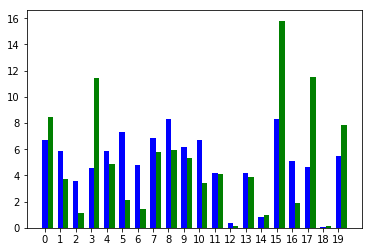

In [199]:
data = [bins, customer_bins]

bar1 = plt.bar(x_label, bins, 0.35, color='b', label='General')
bar2 = plt.bar(x_label + 0.35, customer_bins, 0.35, color='g', label='Customer')
plt.xticks(range(0,20), range(0,20))
plt.show()


In [200]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#Cluster #15 is an example whereby customer data is overrepresented vs general

cluster_centroid= scaler_model.inverse_transform(pca90.inverse_transform(km_model.cluster_centers_[15]))
a = pd.Series(data=cluster_centroid, index=customers.columns)
print(a)
#NOTE: This represent wealthy group of people with older age older than 45, HH_EINKOMMEN_SCORE is 2.6 which is very high income)
#PROSPEROUS HOUSEHOLD and FAMILIES WITH YOUNG AGE CHILDREN

ALTERSKATEGORIE_GROB       3.854953
ANREDE_KZ                  0.925787
FINANZ_MINIMALIST          5.388050
FINANZ_SPARER              0.889487
FINANZ_VORSORGER           4.989179
FINANZ_ANLEGER             1.198323
FINANZ_UNAUFFAELLIGER      1.358763
FINANZ_HAUSBAUER           1.717596
GREEN_AVANTGARDE           0.258278
HEALTH_TYP                 2.212842
RETOURTYP_BK_S             4.104450
SEMIO_SOZ                  4.828800
SEMIO_FAM                  4.390554
SEMIO_REL                  3.004760
SEMIO_MAT                  2.537922
SEMIO_VERT                 6.594194
SEMIO_LUST                 5.954472
SEMIO_ERL                  4.731662
SEMIO_KULT                 4.649388
SEMIO_RAT                  1.891089
SEMIO_KRIT                 2.938596
SEMIO_DOM                  3.064870
SEMIO_KAEM                 2.044632
SEMIO_PFLICHT              2.285181
SEMIO_TRADV                2.360837
SOHO_KZ                    0.000678
VERS_TYP                   1.632940
ANZ_PERSONEN               2

In [201]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#Cluster #5 is an example whereby customer data is underrepresented in the general population
cluster_centroid= scaler_model.inverse_transform(pca90.inverse_transform(km_model.cluster_centers_[5]))
a = pd.Series(data=cluster_centroid, index=customers.columns)
print(a)

#HH_EINKOMMEN_SCORE is 4.3 which is average to lower income
#Age is 30-45



ALTERSKATEGORIE_GROB       2.813928
ANREDE_KZ                  0.810711
FINANZ_MINIMALIST          3.386607
FINANZ_SPARER              2.381290
FINANZ_VORSORGER           3.733277
FINANZ_ANLEGER             2.147998
FINANZ_UNAUFFAELLIGER      2.601545
FINANZ_HAUSBAUER           3.196751
GREEN_AVANTGARDE           0.397595
HEALTH_TYP                 2.097721
RETOURTYP_BK_S             3.278622
SEMIO_SOZ                  6.614611
SEMIO_FAM                  6.303630
SEMIO_REL                  4.988868
SEMIO_MAT                  4.897938
SEMIO_VERT                 6.708577
SEMIO_LUST                 4.314480
SEMIO_ERL                  2.432474
SEMIO_KULT                 6.364976
SEMIO_RAT                  3.033288
SEMIO_KRIT                 1.946004
SEMIO_DOM                  2.227444
SEMIO_KAEM                 1.772485
SEMIO_PFLICHT              4.317125
SEMIO_TRADV                3.803810
SOHO_KZ                    0.000706
VERS_TYP                   1.460083
ANZ_PERSONEN               2

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Segment that are populare with the mail-order company are wealthy group of people with age older than 45, has very high income, is a properous houshold, and families with young age children. Financially Minimalist and likes to be prepared.


Segment that unpopular with the company are younger age population, with average or lower income, less affluent household.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.